# Machine Translation + Transformer

In [1]:
import torch, torchdata, torchtext
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
import random, math, time

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

c:\Users\Admin\anaconda3\envs\dsai\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


In [2]:
# torch.cuda.get_device_name(0)

In [3]:
torch.__version__

'2.1.1+cu118'

In [4]:
torchtext.__version__

'0.16.1+cpu'

## 1. ETL: Loading the dataset

**Note**: Here I chose to translate English to German, simply it is easier for myself, since I don't understand German so it is difficult for me to imagine a sentence during inference.

In [5]:
import datasets

SRC_LANGUAGE = 'en'
TRG_LANGUAGE = 'th'

dataset = datasets.load_dataset("opus100", "en-th")

In [6]:
dataset

DatasetDict({
    test: Dataset({
        features: ['translation'],
        num_rows: 2000
    })
    train: Dataset({
        features: ['translation'],
        num_rows: 1000000
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 2000
    })
})

In [7]:
from numpy.random import default_rng

rng = default_rng(seed=SEED)
# create a list of non-repeated indices of size 20000 and use it to select the training samples
select_idx = rng.choice(len(dataset['train']), size=20000, replace=False)
dataset['train'] = dataset['train'].filter(lambda example, idx: idx in select_idx, with_indices=True)

In [8]:
get_lang_col = lambda example, lang: {lang: example['translation'][lang]}
dataset = dataset.map(get_lang_col, fn_kwargs={'lang': "th"})
dataset = dataset.map(get_lang_col, remove_columns=['translation'], fn_kwargs={'lang': "en"})

In [9]:
dataset['train'][2]

{'th': 'พ่อเธอเคยบอกให้เธอหุบปากบ้างมั๊ยล่ะ?',
 'en': 'Has your dad ever told you to shut up?'}

In [10]:
dataset

DatasetDict({
    test: Dataset({
        features: ['th', 'en'],
        num_rows: 2000
    })
    train: Dataset({
        features: ['th', 'en'],
        num_rows: 20000
    })
    validation: Dataset({
        features: ['th', 'en'],
        num_rows: 2000
    })
})

In [11]:
train_set, val_set, test_set = dataset['train'], dataset['validation'], dataset['test']

## 3. Preprocessing 

### Tokenizing

**Note**: the models must first be downloaded using the following on the command line: 
```
python3 -m spacy download en_core_web_sm
python3 -m spacy download de_core_news_sm
```

First, since we have two languages, let's create some constants to represent that.  Also, let's create two dicts: one for holding our tokenizers and one for holding all the vocabs with assigned numbers for each unique word

In [12]:
# !pip install pythainlp

In [13]:
# Place-holders
token_transform = {}
vocab_transform = {}

In [14]:
from torchtext.data.utils import get_tokenizer
from pythainlp.tokenize import Tokenizer

token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')
token_transform[TRG_LANGUAGE] = Tokenizer(engine='newmm')

In [15]:
#example of tokenization of the thai part
print("Sentence: ", dataset['train'][TRG_LANGUAGE][2])
print("Tokenization: ", token_transform[TRG_LANGUAGE].word_tokenize(dataset['train'][TRG_LANGUAGE][2]))

Sentence:  พ่อเธอเคยบอกให้เธอหุบปากบ้างมั๊ยล่ะ?
Tokenization:  ['พ่อ', 'เธอ', 'เคย', 'บอก', 'ให้', 'เธอ', 'หุบปาก', 'บ้าง', 'มั๊ย', 'ล่ะ', '?']


In [16]:
def tokenize_data(example, lang):
    try:
        return {lang: token_transform[lang](example[lang].lower())}
    except:
        return {lang: token_transform[lang].word_tokenize(example[lang].lower())}
    
tokenized_dataset = dataset.map(tokenize_data, remove_columns=[SRC_LANGUAGE], fn_kwargs={'lang': SRC_LANGUAGE})
tokenized_dataset = tokenized_dataset.map(tokenize_data, remove_columns=[TRG_LANGUAGE], fn_kwargs={'lang': TRG_LANGUAGE})

In [17]:
# Define special symbols and indices
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>']

In [18]:
for lang in [SRC_LANGUAGE, TRG_LANGUAGE]:
    vocab_transform[lang] = torchtext.vocab.build_vocab_from_iterator(tokenized_dataset['train'][lang],
                                                                      min_freq=3,   #if not, everything will be treated as UNK
                                                                      specials=special_symbols,
                                                                      special_first=True) #indicates whether to insert symbols at the beginning or at the end)
    # Set UNK_IDX as the default index. This index is returned when the token is not found. 
    # If not set, it throws RuntimeError when the queried token is not found in the Vocabulary. 
    vocab_transform[lang].set_default_index(UNK_IDX)

In [19]:
# save vocab
torch.save(vocab_transform, './models/vocab')

In [20]:
#see some example
vocab_transform[SRC_LANGUAGE](['my', 'precious'])

[36, 2573]

In [21]:
#see some example
vocab_transform[TRG_LANGUAGE](['ของ', 'รัก', 'ของ', 'ข้า'])

[13, 162, 13, 70]

In [22]:
#we can reverse it....
mapping = vocab_transform[TRG_LANGUAGE].get_itos()

#print 1816, for example
mapping[13]

'ของ'

In [23]:
#let's try unknown vocab
mapping[0]
#they will all map to <unk> which has 0 as integer

'<unk>'

In [24]:
#let's try special symbols
mapping[1], mapping[2], mapping[3]

('<pad>', '<sos>', '<eos>')

In [25]:
#check unique vocabularies
len(mapping)

4243

## 4. Preparing the dataloader

One thing we change here is the <code>collate_fn</code> which now also returns the length of sentence.  This is required for <code>packed_padded_sequence</code>

In [26]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

BATCH_SIZE = 64

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            try:
                txt_input = transform(txt_input)
            except TypeError:
                txt_input = transform.word_tokenize(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids):
    return torch.cat((torch.tensor([SOS_IDX]), 
                      torch.tensor(token_ids), 
                      torch.tensor([EOS_IDX])))

# src and trg language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tesors
def collate_batch(batch):
    src_batch, src_len_batch, trg_batch = [], [], []
    for sample in batch:
        processed_text = text_transform[SRC_LANGUAGE](sample[SRC_LANGUAGE].rstrip("\n"))
        src_batch.append(processed_text)
        trg_batch.append(text_transform[TRG_LANGUAGE](sample[TRG_LANGUAGE].rstrip("\n")))
        src_len_batch.append(processed_text.size(0))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX, batch_first=True)
    trg_batch = pad_sequence(trg_batch, padding_value=PAD_IDX, batch_first=True)
    return src_batch, torch.tensor(src_len_batch, dtype=torch.int64), trg_batch

Create train, val, and test dataloaders

In [27]:
batch_size = 64

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(val_set,   batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
test_loader  = DataLoader(test_set,  batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

Let's test the train loader.

In [28]:
for en, _, th in train_loader:
    break

In [29]:
print("English shape: ", en.shape)  # (batch_size, seq len)
print("Thai shape: ", th.shape)   # (batch_size, seq len)

English shape:  torch.Size([64, 36])
Thai shape:  torch.Size([64, 45])


## 5. Design the model

### Encoder Layer

In [30]:
class EncoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, attn_variant, device):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm        = nn.LayerNorm(hid_dim)
        self.self_attention       = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, attn_variant, device)
        self.feedforward          = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout              = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len]   #if the token is padding, it will be 1, otherwise 0
        _src, _ = self.self_attention(src, src, src, src_mask)
        src     = self.self_attn_layer_norm(src + self.dropout(_src))
        #src: [batch_size, src len, hid dim]
        
        _src    = self.feedforward(src)
        src     = self.ff_layer_norm(src + self.dropout(_src))
        #src: [batch_size, src len, hid dim]
        
        return src

### Encoder

In [31]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hid_dim, n_layers, n_heads, pf_dim, dropout, attn_variant, device, max_length = 500):
        super().__init__()
        self.device = device
        self.attn_variant = attn_variant
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers        = nn.ModuleList([EncoderLayer(hid_dim, n_heads, pf_dim, dropout, attn_variant, device)
                                           for _ in range(n_layers)])
        self.dropout       = nn.Dropout(dropout)
        self.scale         = torch.sqrt(torch.FloatTensor([hid_dim])).to(self.device)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = src.shape[0]
        src_len    = src.shape[1]
        
        pos        = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        #pos: [batch_size, src_len]
        
        src        = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        #src: [batch_size, src_len, hid_dim]
        
        for layer in self.layers:
            src = layer(src, src_mask)
        #src: [batch_size, src_len, hid_dim]
        
        return src
            

### Mutli Head Attention Layer

$$ \text{Attention}(Q, K, V) = \text{Softmax} \big( \frac{QK^T}{\sqrt{d_k}} \big)V $$ 

In [32]:
# Default Transformer attention variant
class ScaledAttention(nn.Module):
    def __init__(self, head_dim):
        super().__init__()
        self.scale = torch.sqrt(torch.FloatTensor([head_dim])).to(device)

    def forward(self, Q, K):
        scores = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        # scores: [batch_size, n_heads, query len, key len]

        return scores

In [33]:
class MultiplicativeAttention(nn.Module):
    def __init__(self, head_dim):
        super().__init__()
        self.W1 = nn.Linear(head_dim, head_dim)

    def forward(self, Q, K):
        scores = torch.matmul(self.W1(Q), K.permute(0, 1, 3, 2))
        # scores: [batch_size, n_heads, query len, key len]

        return scores

In [34]:
class AdditiveAttention(nn.Module):
    def __init__(self, head_dim):
        super().__init__()
        self.W1 = nn.Linear(head_dim, head_dim)
        self.W2 = nn.Linear(head_dim, head_dim)
        self.V = nn.Linear(head_dim, 1)

    def forward(self, Q, K):
        Q = Q.unsqueeze(3)  # Q: [batch_size, n_heads, query len, head_dim] => [batch_size, n_heads, query len, 1, head_dim]
        K = K.unsqueeze(2)  # Q: [batch_size, n_heads, key len, head_dim] => [batch_size, n_heads, 1, key len, head_dim]
        features = torch.tanh(self.W1(Q) + self.W2(K))
        # features: [batch_size, n_heads, query len, key len, head_dim]

        scores = self.V(features).squeeze(-1)
        # scores: [batch_size, n_heads, query len, key len]

        return scores

In [35]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, attn_variant, device):
        super().__init__()
        assert hid_dim % n_heads == 0
        self.hid_dim  = hid_dim
        self.n_heads  = n_heads
        self.head_dim = hid_dim // n_heads
        self.attn_variant = attn_variant
        
        self.fc_q     = nn.Linear(hid_dim, hid_dim)
        self.fc_k     = nn.Linear(hid_dim, hid_dim)
        self.fc_v     = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o     = nn.Linear(hid_dim, hid_dim)
        
        self.dropout  = nn.Dropout(dropout)

        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)

        if attn_variant == 'scaled':
            self.scaled_attention = ScaledAttention(self.head_dim)

        elif attn_variant == 'multiplicative':
            self.multiplicative_attention = MultiplicativeAttention(self.head_dim)
        
        elif attn_variant == 'additive':
            self.additive_attention = AdditiveAttention(self.head_dim)
                
    def forward(self, query, key, value, mask = None):
        #src, src, src, src_mask
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
        
        batch_size = query.shape[0]
        
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        # Q: [batch_size, seq len, hid_dim]
        
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        # Q=K=V: [batch_size, n heads, seq len, head_dim]
        
        # energy = self.additive_attention(Q, K)
        if self.attn_variant == "general":
            energy = torch.matmul(Q, K.permute(0, 1, 3, 2))

        elif self.attn_variant == "scaled":
            energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
            # energy = self.scaled_attention(Q, K)

        elif self.attn_variant == "multiplicative":
            energy = self.multiplicative_attention(Q, K)

        elif self.attn_variant == "additive":
            energy = self.additive_attention(Q, K)
            
        else:
            raise Exception("Incorrect value for attention variant. Must be one of the following: \
                            scaled, general, multiplicative, additive")
        
        #for making attention to padding to 0
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
            
        attention = torch.softmax(energy, dim = -1)
        #attention = [batch_size, n heads, query len, key len]

        x = torch.matmul(self.dropout(attention), V)
        #[batch_size, n heads, query len, key len] @ [batch_size, n heads, value len, head_dim]
        #x = [batch_size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()  #we can perform .view
        #x = [batch_size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        #x = [batch_size, query len, hid dim]
        
        x = self.fc_o(x)
        #x = [batch_size, query len, hid dim]
        
        return x, attention
        

### Position-wise Feedforward Layer

In [36]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        self.fc1 = nn.Linear(hid_dim, pf_dim)
        self.fc2 = nn.Linear(pf_dim, hid_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        #x = [batch size, src len, hid dim]
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        
        return x

### Decoder Layer

In [37]:
class DecoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, attn_variant, device):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm  = nn.LayerNorm(hid_dim)
        self.ff_layer_norm        = nn.LayerNorm(hid_dim)
        self.self_attention       = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, attn_variant, device)
        self.encoder_attention    = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, attn_variant, device)
        self.feedforward          = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout              = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        trg     = self.self_attn_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]
        
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        trg             = self.enc_attn_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]
        #attention = [batch_size, n heads, trg len, src len]
        
        _trg = self.feedforward(trg)
        trg  = self.ff_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]
        
        return trg, attention

### Decoder

In [38]:
class Decoder(nn.Module):
    def __init__(self, output_dim, hid_dim, n_layers, n_heads, 
                 pf_dim, dropout, attn_variant, device, max_length = 500):
        super().__init__()
        self.device = device
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers        = nn.ModuleList([DecoderLayer(hid_dim, n_heads, pf_dim, dropout, attn_variant, device)
                                            for _ in range(n_layers)])
        self.fc_out        = nn.Linear(hid_dim, output_dim)
        self.dropout       = nn.Dropout(dropout)
        self.scale         = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = trg.shape[0]
        trg_len    = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        #pos: [batch_size, trg len]
        
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
        #trg: [batch_size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
            
        #trg: [batch_size, trg len, hid dim]
        #attention: [batch_size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        #output = [batch_size, trg len, output_dim]
        
        return output, attention

### Putting them together (become Seq2Seq!)

Our `trg_sub_mask` will look something like this (for a target with 5 tokens):

$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 1 & 0\\
1 & 1 & 1 & 1 & 1\\
\end{matrix}$$

The "subsequent" mask is then logically anded with the padding mask, this combines the two masks ensuring both the subsequent tokens and the padding tokens cannot be attended to. For example if the last two tokens were `<pad>` tokens the mask would look like:

$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
\end{matrix}$$

In [39]:
class Seq2SeqTransformer(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx, device):
        super().__init__()
        # store the input parameters so we can retrive them later for model inferencing
        self.params = {'encoder': encoder, 'decoder': decoder,
                       'src_pad_idx': src_pad_idx, 'trg_pad_idx': trg_pad_idx}
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention

## 6. Training

In [40]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [41]:
input_dim   = len(vocab_transform[SRC_LANGUAGE])
output_dim  = len(vocab_transform[TRG_LANGUAGE])
hid_dim = 256
enc_layers = 3
dec_layers = 3
enc_heads = 8
dec_heads = 8
enc_pf_dim = 512
dec_pf_dim = 512
enc_dropout = 0.1
dec_dropout = 0.1
attn_variant = 'additive'

SRC_PAD_IDX = PAD_IDX
TRG_PAD_IDX = PAD_IDX

enc = Encoder(input_dim, 
              hid_dim, 
              enc_layers, 
              enc_heads, 
              enc_pf_dim, 
              enc_dropout, 
              attn_variant,
              device)

dec = Decoder(output_dim, 
              hid_dim, 
              dec_layers, 
              dec_heads, 
              dec_pf_dim, 
              enc_dropout, 
              attn_variant,
              device)

model = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
model.apply(initialize_weights)

Seq2SeqTransformer(
  (encoder): Encoder(
    (tok_embedding): Embedding(3666, 256)
    (pos_embedding): Embedding(500, 256)
    (layers): ModuleList(
      (0-2): 3 x EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (additive_attention): AdditiveAttention(
            (W1): Linear(in_features=32, out_features=32, bias=True)
            (W2): Linear(in_features=32, out_features=32, bias=True)
            (V): Linear(in_features=32, out_features=1, bias=True)
          )

In [42]:
#we can print the complexity by the number of parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

938496
128000
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
131072
   512
131072
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
131072
   512
131072
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
131072
   512
131072
   256
1086208
128000
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
131072
   512
131072
   256
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
13107

Then, we'll define our training loop. This is the exact same as the one used in the previous tutorial.

As we want our model to predict the `<eos>` token but not have it be an input into our model we simply slice the `<eos>` token off the end of the sequence. Thus:

$$\begin{align*}
\text{trg} &= [sos, x_1, x_2, x_3, eos]\\
\text{trg[:-1]} &= [sos, x_1, x_2, x_3]
\end{align*}$$

$x_i$ denotes actual target sequence element. We then feed this into the model to get a predicted sequence that should hopefully predict the `<eos>` token:

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, eos]
\end{align*}$$

$y_i$ denotes predicted target sequence element. We then calculate our loss using the original `trg` tensor with the `<sos>` token sliced off the front, leaving the `<eos>` token:

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, eos]\\
\text{trg[1:]} &= [x_1, x_2, x_3, eos]
\end{align*}$$

We then calculate our losses and update our parameters as is standard.

In [43]:
def train(model, loader, optimizer, criterion, clip, loader_length):
    
    model.train()
    
    epoch_loss = 0
    
    for src, src_len, trg in loader:
        
        src = src.to(device)
        trg = trg.to(device)
        
        optimizer.zero_grad()
        
        #trg[:, :-1] remove the eos, e.g., "<sos> I love sushi" since teaching forcing, the input does not need to have eos
        output, _ = model(src, trg[:,:-1])
                
        #output = [batch size, trg len - 1, output dim]
        #trg    = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.reshape(-1, output_dim)
        trg = trg[:,1:].reshape(-1) #trg[:, 1:] remove the sos, e.g., "i love sushi <eos>" since in teaching forcing, the output does not have sos
                
        #output = [batch size * trg len - 1, output dim]
        #trg    = [batch size * trg len - 1]
            
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / loader_length

Our evaluation loop is similar to our training loop, however as we aren't updating any parameters we don't need to pass an optimizer or a clip value.

In [44]:
def evaluate(model, loader, criterion, loader_length):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for src, src_len, trg in loader:
        
            src = src.to(device)
            trg = trg.to(device)

            output, _ = model(src, trg[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / loader_length

### Putting everything together

Finally, we train our actual model. This model is almost 3x faster than the convolutional sequence-to-sequence model and also achieves a lower validation perplexity!

**Note: similar to CNN, this model always has a teacher forcing ratio of 1, i.e. it will always use the ground truth next token from the target sequence (this is simply because CNN do everything in parallel so we cannot have the next token). This means we cannot compare perplexity values against the previous models when they are using a teacher forcing ratio that is not 1. To understand this, try run previous tutorials with teaching forcing ratio of 1, you will get very low perplexity.  **   

In [45]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [46]:
import gc

input_dim   = len(vocab_transform[SRC_LANGUAGE])
output_dim  = len(vocab_transform[TRG_LANGUAGE])

batch_size = 64
lr = 0.0005
hid_dim = 256
enc_layers = 3
dec_layers = 3
enc_heads = 8
dec_heads = 8
enc_pf_dim = 512
dec_pf_dim = 512
enc_dropout = 0.1
dec_dropout = 0.1

SRC_PAD_IDX = PAD_IDX
TRG_PAD_IDX = PAD_IDX

num_epochs = 10
clip       = 1

model_losses = {}

for attn_variant in ['additive', 'multiplicative', 'general', 'scaled']:

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
    valid_loader = DataLoader(val_set,   batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
    test_loader  = DataLoader(test_set,  batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

    train_loader_length = len(list(iter(train_loader)))
    val_loader_length   = len(list(iter(valid_loader)))
    test_loader_length  = len(list(iter(test_loader)))

    enc = Encoder(input_dim,
                  hid_dim, 
                  enc_layers, 
                  enc_heads, 
                  enc_pf_dim, 
                  enc_dropout, 
                  attn_variant, 
                  device)

    dec = Decoder(output_dim, 
                  hid_dim, 
                  dec_layers, 
                  dec_heads, 
                  dec_pf_dim, 
                  enc_dropout, 
                  attn_variant, 
                  device)

    model = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
    model.apply(initialize_weights)

    #training hyperparameters
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX) #combine softmax with cross entropy

    save_path = f'models/{attn_variant}_{model.__class__.__name__}.pt'

    best_valid_loss = float('inf')
    train_losses = []
    valid_losses = []

    print(f'\n===== {attn_variant} =====')

    for epoch in range(num_epochs):
        
        start_time = time.time()

        train_loss = train(model, train_loader, optimizer, criterion, clip, train_loader_length)
        valid_loss = evaluate(model, valid_loader, criterion, val_loader_length)
        
        #for plotting
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        
        end_time = time.time()
        
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save([model.params, model.state_dict()], save_path)
            # torch.save([model.params, model.state_dict()], save_path)
        
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
        
        #lower perplexity is better

    model_losses[attn_variant] = {"train loss": train_losses, "valid loss": valid_losses, "best valid loss": best_valid_loss}
    
    # empty gpu cache to clear memory
    del enc, dec, model
    torch.cuda.empty_cache()
    gc.collect()


===== additive =====
Epoch: 01 | Time: 3m 53s
	Train Loss: 5.314 | Train PPL: 203.219
	 Val. Loss: 4.762 |  Val. PPL: 116.950
Epoch: 02 | Time: 6m 6s
	Train Loss: 4.574 | Train PPL:  96.924
	 Val. Loss: 4.500 |  Val. PPL:  90.016
Epoch: 03 | Time: 7m 10s
	Train Loss: 4.237 | Train PPL:  69.183
	 Val. Loss: 4.386 |  Val. PPL:  80.308
Epoch: 04 | Time: 4m 55s
	Train Loss: 3.966 | Train PPL:  52.796
	 Val. Loss: 4.312 |  Val. PPL:  74.589
Epoch: 05 | Time: 3m 50s
	Train Loss: 3.729 | Train PPL:  41.634
	 Val. Loss: 4.295 |  Val. PPL:  73.297
Epoch: 06 | Time: 4m 14s
	Train Loss: 3.504 | Train PPL:  33.255
	 Val. Loss: 4.304 |  Val. PPL:  73.965
Epoch: 07 | Time: 4m 21s
	Train Loss: 3.298 | Train PPL:  27.052
	 Val. Loss: 4.324 |  Val. PPL:  75.474
Epoch: 08 | Time: 4m 2s
	Train Loss: 3.104 | Train PPL:  22.288
	 Val. Loss: 4.358 |  Val. PPL:  78.117
Epoch: 09 | Time: 3m 41s
	Train Loss: 2.918 | Train PPL:  18.507
	 Val. Loss: 4.432 |  Val. PPL:  84.097
Epoch: 10 | Time: 3m 44s
	Train Los

Text(0, 0.5, 'loss')

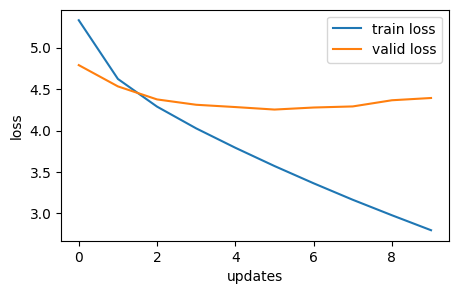

In [47]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

In [48]:
params, state = torch.load(save_path)
model = Seq2SeqTransformer(**params, device=device).to(device)
model.load_state_dict(state)
test_loss = evaluate(model, test_loader, criterion, test_loader_length)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 4.278 | Test PPL:  72.065 |


## 7. Test on some random news

In [49]:
test_set[0]['en']

"No. It's fine. I'm just glad you're OK."

In [50]:
test_set[0]['th']

'ไม่ ไม่เป็นไร ฉันดีใจที่คุณโอเค'

In [51]:
src_text = text_transform[SRC_LANGUAGE](test_set[0]['en']).to(device)
src_text

tensor([  2,   0,   4,   0,  11, 267,   4,   0,  37,  44, 653,   6,  38,   0,
          4,   3], device='cuda:0')

In [52]:
trg_text = text_transform[TRG_LANGUAGE](test_set[0]['th']).to(device)
trg_text

tensor([  2,   6,   4, 217,   4,   5, 518,   8,   7, 124,   3],
       device='cuda:0')

In [53]:
src_text = src_text.reshape(1, -1)  #because batch_size is 1

In [54]:
trg_text = trg_text.reshape(1, -1)

In [55]:
src_text.shape, trg_text.shape

(torch.Size([1, 16]), torch.Size([1, 11]))

In [56]:
text_length = torch.tensor([src_text.size(0)]).to(dtype=torch.int64)

In [57]:
# let's pick one of our model, in this case the additive model
load_path = 'models/additive_Seq2SeqTransformer.pt'

params, state = torch.load(save_path)
model = Seq2SeqTransformer(**params, device=device).to(device)
model.load_state_dict(state)

model.eval()
with torch.no_grad():
    output, attentions = model(src_text, trg_text) #turn off teacher forcing

In [58]:
output.shape #batch_size, trg_len, trg_output_dim

torch.Size([1, 11, 4243])

Since batch size is 1, we just take off that dimension

In [59]:
output = output.squeeze(0)

In [60]:
output.shape

torch.Size([11, 4243])

We shall remove the first token since it's zeroes anyway

In [61]:
output = output[1:]
output.shape #trg_len, trg_output_dim

torch.Size([10, 4243])

Then we just take the top token with highest probabilities

In [62]:
output_max = output.argmax(1) #returns max indices

In [63]:
output_max

tensor([ 4,  5,  4,  5, 64,  8, 62, 88,  3,  3], device='cuda:0')

Get the mapping of the target language

In [64]:
mapping = vocab_transform[TRG_LANGUAGE].get_itos()

In [65]:
for token in output_max:
    print(mapping[token.item()])

 
ฉัน
 
ฉัน
แค่
ที่
ดี
พูด
<eos>
<eos>


## 8. Attention

Let's display the attentions to understand how the source text links with the generated text

In [66]:
attentions.shape

torch.Size([1, 8, 11, 16])

Since there are 8 heads, we can look at just 1 head for sake of simplicity.

In [67]:
attention = attentions[0, 0, :, :]
attention.shape

torch.Size([11, 16])

In [68]:
src_tokens = ['<sos>'] + token_transform[SRC_LANGUAGE](test_set[0]['en']) + ['<eos>']
src_tokens

['<sos>',
 'No',
 '.',
 'It',
 "'s",
 'fine',
 '.',
 'I',
 "'m",
 'just',
 'glad',
 'you',
 "'re",
 'OK',
 '.',
 '<eos>']

In [69]:
trg_tokens = ['<sos>'] + [mapping[token.item()] for token in output_max]
trg_tokens

['<sos>', ' ', 'ฉัน', ' ', 'ฉัน', 'แค่', 'ที่', 'ดี', 'พูด', '<eos>', '<eos>']

In [70]:
import matplotlib.ticker as ticker

def display_attention(sentence, translation, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(1).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=10)
    
    y_ticks =  [''] + translation
    x_ticks =  [''] + sentence 
     
    ax.set_xticklabels(x_ticks, rotation=45)
    ax.set_yticklabels(y_ticks)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

C:\Users\Admin\AppData\Local\Temp\ipykernel_10016\59549304.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_ticks, rotation=45)
C:\Users\Admin\AppData\Local\Temp\ipykernel_10016\59549304.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(y_ticks)
c:\Users\Admin\anaconda3\envs\dsai\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 3593 (\N{THAI CHARACTER CHO CHING}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Admin\anaconda3\envs\dsai\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 3633 (\N{THAI CHARACTER MAI HAN-AKAT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Admin\anaconda3\envs\dsai\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 3609 (\N{THAI 

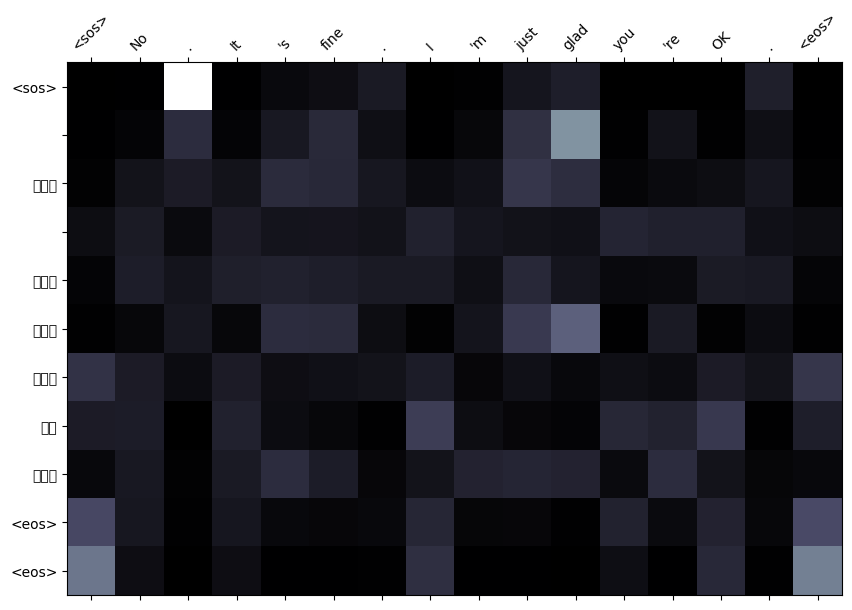

In [71]:
display_attention(src_tokens, trg_tokens, attention)